In [1]:
import jpype
jpype.startJVM(jpype.getDefaultJVMPath())

In [2]:
import multiprocessing as mp
import os 
from __future__ import print_function
import pybobyqa
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import glob
import json
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.myjson.encoder import myJSONDecoder
from os import walk
import matplotlib.dates as mdates
import pickle
from datetime import datetime
from scipy.optimize import curve_fit
from skimage import filters
from scipy import integrate
import logging
import requests
from madxtools.plot_tool import *

def my_mpl_style():
    '''Sets my preferred style options for matplotlib.'''
    import matplotlib as mpl
    # Font sizes
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['legend.fontsize'] = 14
    mpl.rcParams['axes.titlesize'] = 20  # Change the number for your preferred fontsize
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['axes.formatter.limits'] = (-2, 3)
my_mpl_style()

In [3]:
# start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/small_df/"
start_path = "../quad_scan_east_slow_ions_2023_2gev/df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
filenames = sorted(filenames)

# Select all measurements available
new_df = pd.DataFrame()

j = 0
for i in range(len(filenames)):
    with open(start_path+filenames[i], 'rb') as handle:
        df = pickle.load(handle)
        print(filenames[i])
    new_df = pd.concat([new_df,df])

new_df.reset_index(inplace=True)

quad_scan_east_slow_ions_2023_2GeV_2023_09_05_12h15m10s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h19m11s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_13h57m22s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_14h37m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_15h13m20s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_09_05_16h19m47s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_09h23m05s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h11m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_10h57m45s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h32m04s_df.pickle
quad_scan_east_slow_ions_2023_2GeV_2023_10_02_11h56m29s_df.pickle


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

def manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, L, scattering=False):
    """
    This function manipulates the global variables of a MADX instance and returns the new beta functions and emittance.
    If the scattering parameter is set to True, it also calculates the new emittance due to scattering.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    exn (float): The normalized horizontal emittance.
    eyn (float): The normalized vertical emittance.
    p (float): The momentum of the beam.
    beta (float): The relativistic beta factor.
    gamma (float): The relativistic gamma factor.
    L (float): The length of the air region.
    scattering (bool): A boolean indicating whether to calculate the new emittance due to scattering.

    Returns:
    betx0 (float): The new horizontal beta function.
    bety0 (float): The new vertical beta function.
    alfx0 (float): The new horizontal alpha function.
    alfy0 (float): The new vertical alpha function.
    dx0 (float): The new horizontal dispersion.
    dy0 (float): The new vertical dispersion.
    dpx0 (float): The new horizontal momentum deviation.
    dpy0 (float): The new vertical momentum deviation.
    exn (float): The new horizontal emittance.
    eyn (float): The new vertical emittance.
    """

    madx.globals['betx0'] = 'savebeta_air->betx'
    madx.globals['bety0'] = 'savebeta_air->bety'
    madx.globals['alfx0'] = 'savebeta_air->alfx'
    madx.globals['alfy0'] = 'savebeta_air->alfy'
    madx.globals['dx0'] = 'savebeta_air->dx'
    madx.globals['dy0'] = 'savebeta_air->dy'
    madx.globals['dpx0'] = 'savebeta_air->dpx'
    madx.globals['dpy0'] = 'savebeta_air->dpy'

    if scattering==True:
        
        epsilon_0 = exn/(beta*gamma)
        epsilon_0_V = eyn/(beta*gamma)

        p_MeV = p*1000 # Beam total energy in MeV
        q = 1
        P = 1.01325 # Standard air pressure at sea level in Bar
        P_Torr = P*750.062 # Standard air pressure at sea level in Torr
        L_rad0 = 301 # For air. Table with radiation lengths: https://cds.cern.ch/record/941314/files/p245.pdf
        L_rad = L_rad0/(P_Torr/760)

        theta_rms = (13.6/p_MeV*beta)*q*np.sqrt(L/L_rad)

        # Horizontal
        gamma0 = (1 + madx.globals['alfx0']**2) / madx.globals['betx0']
        Delta_epsilon = (1/2)*theta_rms**2*(madx.globals['betx0'] + L*madx.globals['alfx0'] + (L**2/3)*gamma0)
        epsilon_1 = epsilon_0 + Delta_epsilon
        alfx0_1 = (epsilon_0*madx.globals['alfx0'] - (L/2)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)
        betx0_1 = (epsilon_0*madx.globals['betx0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0 + Delta_epsilon)

        # Vertical
        gamma0_V = (1 + madx.globals['alfy0']**2) / madx.globals['bety0']
        Delta_epsilon_V = (1/2)*theta_rms**2*(madx.globals['bety0'] + L*madx.globals['alfy0'] + (L**2/3)*gamma0_V)
        epsilon_1_V = epsilon_0_V + Delta_epsilon_V
        alfy0_1 = (epsilon_0_V*madx.globals['alfy0'] - (L/2)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)
        bety0_1 = (epsilon_0_V*madx.globals['bety0'] + (L**2/3)*theta_rms**2 ) / (epsilon_0_V + Delta_epsilon_V)

        # Return
        exn = epsilon_1*beta*gamma
        eyn = epsilon_1_V*beta*gamma
        betx0 = betx0_1
        alfx0 = alfx0_1
        bety0 = bety0_1
        alfy0 = alfy0_1
        
    else:
        betx0 = madx.globals['betx0']
        alfx0 = madx.globals['alfx0']
        bety0 = madx.globals['bety0']
        alfy0 = madx.globals['alfy0']
    
    dx0 = madx.globals['dx0']
    dy0 = madx.globals['dy0']
    dpx0 = madx.globals['dpx0']
    dpy0 = madx.globals['dpy0']

    return betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, exn, eyn

def add_air_region(madx, title, sequence, air_start_pos, air_stop_pos, steps):
    """
    This function adds an air region to the MADX sequence.

    Parameters:
    madx (cpymad.madx.Madx): An instance of the MADX class.
    air_start_pos (float): The starting position of the air region.
    air_stop_pos (float): The stopping position of the air region.
    steps (float): The distance between two consecutive inner markers.

    Returns:
    None
    """

    # Calculate the positions of the inner markers
    inner_marker_array = np.arange(air_start_pos+steps, air_stop_pos, steps)

    # Add the markers for the start and end of the air region
    madx.input(f'''
    AIR_START : MARKER;
    AIR_END : MARKER;
    ''')           

    # Install the markers for the start and end of the air region
    madx.input(f'''
    SEQEDIT, SEQUENCE={sequence};
    INSTALL, ELEMENT=AIR_START, CLASS=AIR_START, AT={air_start_pos};
    INSTALL, ELEMENT=AIR_END, CLASS=AIR_END, AT={air_stop_pos};
    ENDEDIT;
    ''')

    # Add the inner markers
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    # Create a for loop for the inner markers:
    for count, pos in enumerate(inner_marker_array):
        madx.input(f"INSTALL, ELEMENT=INNER_MARKER{str(count)}_{title}, CLASS=MARKER, AT={pos};")
        # print(f"INNER_MARKER{str(count)}")
    madx.input("ENDEDIT;")

    return

def add_hidden_marker(madx, sequence, start, stop, steps):
    # Add marker at the end of the line to see the evolution of the beam with fine resolution
    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    for count, pos in enumerate(np.arange(start, stop, steps)):
        madx.input(f"INSTALL, ELEMENT=HIDDEN_MARKER{str(count)}, CLASS=MARKER, AT={pos};")
    madx.input("ENDEDIT;")

    return

def process_scattering(madx, exn, eyn, beta, gamma, sequence, end, p, twiss_initial, ex_initial, ey_initial):

    air_start_elements = [name for name in twiss_initial.name if "air_start" in name]
    # print(f"There are {len(air_start_elements)} air regions in the sequence: {air_start_elements}")

    air_start_numbers = [int(name.split(':')[1]) for name in air_start_elements]
    # print(f"The air regions are numbered: {air_start_numbers}")

    inner_elements = [name for name in twiss_initial.name if "inner" in name]

    def update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list):
        madx.command.beam(ex=exn/(beta*gamma), ey=eyn/(beta*gamma))
        ex_list.append(madx.sequence[sequence].beam.ex)
        ey_list.append(madx.sequence[sequence].beam.ey)
        return madx, ex_list, ey_list

    def append_twiss_to_list(madx, sequence, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0):
        madx.use(sequence=sequence)
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()
        twiss_list.append(twiss)
        return twiss_list

    twiss_list = []
    ex_list = []
    ey_list = []

    betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=False, L=0)

    madx.input(f"SEQEDIT, SEQUENCE = {sequence};")
    madx.input(f"EXTRACT, SEQUENCE = {sequence}, FROM=AIR_START, TO={end}, NEWNAME=seq_air_start_to_end;")
    madx.input("ENDEDIT;")

    previous_seq_name = "seq_air_start_to_end"

    # Iterating over all air regions
    for air_region_number in air_start_numbers:
        # print(f"Entering air region {air_region_number}")

        if air_region_number == 1:
            air_start_pos = madx.sequence[sequence].elements["air_start"].position

        else:
            air_start_pos = madx.sequence[sequence].elements[f"air_start[{str(air_region_number)}]"].position

        # print(air_start_pos)

        inner_marker_list = [name for name in inner_elements if name.endswith(f"{air_region_number}:1")]
        for i in range(len(inner_marker_list)):

            if i == 0:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - air_start_pos
            else:
                step = madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position - madx.sequence[sequence].elements[inner_marker_list[i-1][:-2]].position

            madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

            # print(f"SAVEBETA at INNER_MARKER{str(i)}_{str(air_region_number)}")
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = INNER_MARKER{str(i)}_{str(air_region_number)}, SEQUENCE={previous_seq_name};")
            twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
            betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)

            # print(f"Extracting from INNER_MARKER{str(i)}_{str(air_region_number)} to {end}")
            madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=INNER_MARKER{str(i)}_{str(air_region_number)}, TO={end}, NEWNAME=seq_inner_marker{str(i)}_to_end;")
            madx.input("ENDEDIT;")

            previous_seq_name = f"seq_inner_marker{str(i)}_to_end"
        
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)

        #### Air_END ####
        # Final step calculation
        if air_region_number == 1:
            air_end_pos = madx.sequence[sequence].elements["air_end"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position
        else:
            air_end_pos = madx.sequence[sequence].elements[f"air_end[{str(air_region_number)}]"].position
            step = air_end_pos - madx.sequence[sequence].elements[inner_marker_list[i][:-2]].position

        # print(f"SAVEBETA at AIR_END")
        if air_region_number == 0:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END, SEQUENCE={previous_seq_name};")
        else:
            madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_END[{str(air_region_number)}], SEQUENCE={previous_seq_name};")

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0, exn, eyn = manipulate_globals_and_return(madx, exn, eyn, p, beta, gamma, scattering=True, L=step)
        
        madx.input(f"SEQEDIT, SEQUENCE = {previous_seq_name};")
        if air_region_number == 1:
            # print(f"Extracting from AIR_END to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end_to_end;")
        else:
            # print(f"Extracting from AIR_END[{str(air_region_number)}] to {end}")
            madx.input(f"EXTRACT, SEQUENCE= {previous_seq_name}, FROM=AIR_END, TO={end}, NEWNAME=seq_air_end{str(air_region_number)}_to_end;")
        madx.input("ENDEDIT;")

        
        if air_region_number == 1:
            previous_seq_name = f"seq_air_end_to_end"
        else:
            previous_seq_name = f"seq_air_end{str(air_region_number)}_to_end"

        twiss_list = append_twiss_to_list(madx,previous_seq_name, twiss_list, betx0, bety0, alfx0, alfy0, Dx0, Dy0, Dpx0, Dpy0)
        madx, ex_list, ey_list = update_beam(madx, exn, eyn, beta, gamma, ex_list, ey_list)


    # Shift the s position so that is is coherent.
    for i in range(len(twiss_list)):
        twiss_list[i].s = twiss_list[i].s + twiss_initial.loc[twiss_list[i].iloc[1].name].s


    # We add the emittances to each twiss table
    twiss_initial['ex'] = ex_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ex'] = ex_list[i]

    twiss_initial['ey'] = ey_initial

    for i in range(len(twiss_list)):
        twiss_list[i]['ey'] = ey_list[i]

    # We remove the drifts as they are duplicated names
    def remove_drift_rows(df):
        df = df.loc[~df.index.str.startswith('drift')]
        df = df.loc[~df.index.str.startswith('#s')]
        return df

    twiss_list = [remove_drift_rows(df) for df in twiss_list]

    # We combine all the twiss tables into one
    def add_missing_rows(df1, df2):
        # Find rows in df1 with lower 's' than the minimum 's' in df2
        missing_rows = df1[df1['s'] < df2['s'].min()]
        
        # Append these rows to df2 and sort by 's'
        df2_updated = pd.concat([df2, missing_rows]).sort_values(by='s')

        return df2_updated

    # Loop through each element in the list
    for i in range(1, len(twiss_list)):
        twiss_list[i] = add_missing_rows(twiss_list[i-1], twiss_list[i])

    # Finaly, we add the initial twiss table to the beginning
    twiss_scattered = add_missing_rows(twiss_initial, twiss_list[-1])

    return twiss_initial, twiss_scattered

In [5]:
E_cin_per_nucleon = 2

# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

rho = 70.0789
Brho = 3.33564 * p / charge

E_cin_proton = np.sqrt(Brho ** 2 + m_proton_GeV ** 2) - m_proton_GeV


B = 3.3356*p/(rho*charge)*10000

print(f"p = {round(p,3)}")
print(f"Brho = {round(Brho/3.3356,3)}")
print(f"B-field = {round(B,1)} [G]")
print(f"E cin proton = {round(E_cin_proton,1)}")

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

exn = 7.6e-6
eyn = 3.5e-6

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)


p = 578.14
Brho = 10.706
B-field = 5096.0 [G]
E cin proton = 34.8


In [6]:
def beam_size(beta, dispersion, eps, dpp, n):
    """
    Simple calculation of beam size
    """
    beam = np.sqrt(eps*beta + (dpp*dispersion)**2)
    return beam*n


def plot_graph(twiss, ex, sige, ey, fontsize=16, figsize=(10,4), height_ratios=[1,3,3,3]):
    
    fig, ax = plt.subplots(4,1, figsize=figsize, tight_layout=True, sharex=True, height_ratios=height_ratios)
    
    draw_synoptic(ax[0], twiss)
    
    ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0, ls="--")
    ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0, ls="--")
    ax[1].set_xlim(0,twiss.s[-1])
    
    ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0, ls="--")
    ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0, ls="--")
    ax[2].set_xlim(0,twiss.s[-1])
    
    ax[1].grid()
    ax[1].set_ylim(-0.12, 0.12)
    ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)
    
    ax[2].grid()
    ax[2].set_ylim(-0.12, 0.12)
    ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)
    
    ax[3].plot(twiss.s, twiss.betx, alpha=1.0, color ="darkblue", zorder=0, label="betx")
    ax[3].plot(twiss.s, twiss.bety, alpha=1.0, color ="darkred", zorder=0, label="bety")
    ax[3].set_xlim(0,twiss.s[-1])
    
    ax[3].legend()
    ax[3].set_ylim(0, 200)
    ax[3].grid()
    ax[3].set_ylabel(r"$\beta$ [m]", fontsize=fontsize)
    
    draw_aperture_circle(ax[1], twiss, "aper_1")
    draw_aperture_circle(ax[2], twiss, "aper_1")
    draw_aperture_rectangle(ax[1], twiss, "aper_1")
    draw_aperture_rectangle(ax[2], twiss, "aper_2")
    draw_aperture_racetrackH(ax[1], twiss, "aper_1", "aper_2", "aper_3", "aper_4")
    draw_aperture_racetrackV(ax[2], twiss, "aper_1", "aper_2", "aper_3", "aper_4")

    # plt.show()
    return fig, ax

In [12]:
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import clear_output


with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

twiss_saved = 0
H_sigma_saved = 0
V_sigma_saved = 0

def compute(E_cin_per_nucleon, betx0, alfx0, dx0, dpx0, exn, bety0, alfy0, dy0, dpy0, eyn, sige):
    global madx
    global twiss_saved
    global H_sigma_saved
    global V_sigma_saved
    with output:
        clear_output(wait=True)

        fig, ax = plt.subplots(1,2, figsize=(20, 4))

        btv="f61.btv010"

        # dx0 = 0.13
        # dy0 = 0.0
        # dpx0 = 0.02
        # dpy0 = 0

        # exn = 7.6e-6
        # eyn = 3.5e-6
        # sige = 6.79e-4
                     

        # Ion properties
        A = 208.0
        Z = 82.0
        N = 126.0
        charge = 54.0
        m_proton_GeV = 0.93828
        m_neutron_GeV = 0.93957
        m_electron_GeV = 0.000511
        m_u_GeV = 0.9315
        mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
        E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

        p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)
        print(f"p = {round(p/charge,3)}")

        gamma = p/charge/0.938
        beta = np.sqrt(1-gamma**(-2))

        ex = exn/(beta*gamma)
        ey = eyn/(beta*gamma)
        ex_initial = ex
        ey_initial = ey

        madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')
        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
        madx.use(sequence="f61d")

        H_sigma_madx_list = []
        V_sigma_madx_list = []

        for i in range(len(new_df)):

            k_qfn01 = new_df.iloc[i].k_qfn01
            k_qdn02 = new_df.iloc[i].k_qdn02
            k_qfn03 = new_df.iloc[i].k_qfn03

            madx.input("kQFN1 = "+str(k_qfn01)+";")
            madx.input("kQDN2 = "+str(k_qdn02)+";")
            madx.input("kQFN3 = "+str(k_qfn03)+";")

            twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
            # *[ ] add air scattering

            H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
            V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

            H_sigma_madx_list.append(H_sigma_madx)
            V_sigma_madx_list.append(V_sigma_madx)

            if meas_to_inspect.value == i:
                print(meas_to_inspect.value)
                twiss_saved = twiss_f61d
                H_sigma_saved = new_df.iloc[i].sigH/1000
                V_sigma_saved = new_df.iloc[i].sigV/1000

                ax[0].scatter(i, H_sigma_saved*1000, s=100, c="magenta", zorder=99)
                ax[1].scatter(i, V_sigma_saved*1000, s=100, c="magenta", zorder=99)

                ax_save0 = ax[0]
                ax_save1 = ax[1]

        
        ax[0].plot(H_sigma_madx_list, marker="o", label="MAD-X")
        ax[0].plot(new_df.sigH, marker="o", label="Measurements")
        ax[0].legend(loc="upper left")

        ax[1].plot(V_sigma_madx_list, marker="o", label="MAD-X")
        ax[1].plot(new_df.sigV, marker="o", label="Measurements")
        ax[1].legend(loc="upper left")

        ax[0].set_ylabel(r"$\sigma_{H}$ [mm]")
        ax[0].set_ylabel("shot number")
        ax[0].set_ylim(0,30)
        ax[1].set_ylabel(r"$\sigma_{V}$ [mm]")
        ax[1].set_ylabel("shot number")
        ax[1].set_ylim(0,30)

        my_sige = sige
        print(my_sige)
        print(type(my_sige))
        print(type(ey))

        fig, ax = plot_graph(twiss_saved, ex, my_sige, ey, figsize=(25,10))
        ax[1].scatter(twiss_saved['s'][btv], H_sigma_saved, s=100, marker="x", c="b",)
        ax[1].scatter(twiss_saved['s'][btv], -H_sigma_saved, s=100, marker="x", c="b",)
        ax[2].scatter(twiss_saved['s'][btv], V_sigma_saved, s=100, marker="x", c="r",)
        ax[2].scatter(twiss_saved['s'][btv], -V_sigma_saved, s=100, marker="x", c="r",)


        ######################
        ### Air Scattering ###
        ######################
        # Add the Air region
        with open('tempfile', 'w') as f:
            madx = Madx(stdout=f,stderr=f)
            madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
        madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
        madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
        madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
        madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
        madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')
        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
        madx.use(sequence="f61d")

        print("Computing air scattering")
        sequence = "f61d"

        p1 = madx.sequence['f61d'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
        p2 = madx.sequence['f61d'].elements["f61.btv012"].position
        add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

        p1 = madx.sequence['f61d'].elements["f61.bctf022"].position
        p2 = madx.sequence['f61d'].elements["f61.mbxhd025"].position + madx.sequence['f61d'].elements["f61.mbxhd025"].length + 0.3
        add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

        madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')
        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
        madx.use(sequence="f61d")

        # make thin
        madx.use(sequence="f61d")
        madx.input('SEQEDIT, sequence=f61d;')
        madx.input('FLATTEN;')
        madx.input('ENDEDIT;')
        madx.use(sequence="f61d")
        madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
        # madx.input("MAKETHIN, SEQUENCE=f61d, style=TEAPOT")
        madx.use(sequence="f61d")

        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        k_qfn01 = new_df.iloc[meas_to_inspect.value].k_qfn01
        k_qdn02 = new_df.iloc[meas_to_inspect.value].k_qdn02
        k_qfn03 = new_df.iloc[meas_to_inspect.value].k_qfn03

        madx.input("kQFN1 = "+str(k_qfn01)+";")
        madx.input("kQDN2 = "+str(k_qdn02)+";")
        madx.input("kQFN3 = "+str(k_qfn03)+";")

        madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
        twiss, twiss_scattered = process_scattering(madx, exn, eyn, beta, gamma, sequence, "f61.end", p/charge, twiss, ex_initial, ey_initial)

        H_sigma_madx_scattered = ( beam_size(twiss_scattered['betx'][btv], twiss_scattered['dx'][btv], twiss_scattered['ex'][btv], sige, 1) )*1000
        V_sigma_madx_scattered = ( beam_size(twiss_scattered['bety'][btv], twiss_scattered['dy'][btv], twiss_scattered['ey'][btv], sige, 1) )*1000

        ax[1].plot(twiss_scattered['s'], beam_size(twiss_scattered['betx'], twiss_scattered['dx'], twiss_scattered['ex'], sige, 1)+twiss_scattered.x, alpha=1.0, color ="b", zorder=0)
        ax[1].plot(twiss_scattered['s'], -beam_size(twiss_scattered['betx'], twiss_scattered['dx'], twiss_scattered['ex'], sige, 1)+twiss_scattered.x, alpha=1.0, color ="b", zorder=0)

        ax[2].plot(twiss_scattered['s'], beam_size(twiss_scattered['bety'], twiss_scattered['dy'], twiss_scattered['ey'], sige, 1)+twiss_scattered.y, alpha=1.0, color ="r", zorder=0)
        ax[2].plot(twiss_scattered['s'], -beam_size(twiss_scattered['bety'], twiss_scattered['dy'], twiss_scattered['ey'], sige, 1)+twiss_scattered.y, alpha=1.0, color ="r", zorder=0)

        ax_save0.scatter(meas_to_inspect.value, H_sigma_madx_scattered, c="cyan", s=50, zorder=99)
        ax_save1.scatter(meas_to_inspect.value, V_sigma_madx_scattered, c="cyan", s=50, zorder=99)

        plt.show()

betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn0 = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn0 = 6.94e-06

sige0 = 0.0045

meas_to_inspect = widgets.IntSlider(value=0,
    min=0,
    max=len(new_df),
    step=1,
    description='Measurement to inspect',
    layout=Layout(width='1000px'))

Ecin = widgets.FloatSlider(value=2,
    min=0.5,
    max=5,
    step=0.1,
    description='Ecin',
    layout=Layout(width='1000px'))

betx = widgets.FloatSlider(value=betx0,
    min=1,
    max=200,
    step=0.01,
    description='betx',
    layout=Layout(width='500px'))

alfx = widgets.FloatSlider(value=alfx0,
    min=-50,
    max=50,
    step=0.01,
    description='alfx',
    layout=Layout(width='500px'))

dx = widgets.FloatSlider(value=dx0,
    min=-5,
    max=5,
    step=0.01,
    description='dx',
    layout=Layout(width='500px'))

dpx = widgets.FloatSlider(value=dpx0,
    min=-5,
    max=5,
    step=0.01,
    description='dpx',
    layout=Layout(width='500px'))

exn = widgets.FloatSlider(value=exn0,
    min=1e-6,
    max=50e-6,
    step=0.1e-6,
    description='exn',
    layout=Layout(width='500px'),
    readout_format='.1e',)

bety = widgets.FloatSlider(value=bety0,
    min=1,
    max=20,
    step=0.01,
    description='bety',
    layout=Layout(width='500px'))

alfy = widgets.FloatSlider(value=alfy0,
    min=-5,
    max=5,
    step=0.01,
    description='alfy',
    layout=Layout(width='500px'))

dy = widgets.FloatSlider(value=dy0,
    min=-5,
    max=5,
    step=0.01,
    description='dy',
    layout=Layout(width='500px'))

dpy = widgets.FloatSlider(value=dpy0,
    min=-5,
    max=5,
    step=0.01,
    description='dpy',
    layout=Layout(width='500px'))

eyn = widgets.FloatSlider(value=eyn0,
    min=1e-6,
    max=50e-6,
    step=0.1e-6,
    description='eyn',
    layout=Layout(width='500px'),
    readout_format='.1e',)

sige = widgets.FloatSlider(value=sige0,
    min=20e-4,
    max=50e-4,
    step=0.1e-4,
    description='sige',
    layout=Layout(width='1000px'),
    readout_format='.1e',)

output = widgets.Output()
button = widgets.Button(description="Simulate")



display(widgets.VBox([Ecin, widgets.HBox([widgets.VBox([betx, alfx, dx, dpx, exn]), widgets.VBox([bety, alfy, dy, dpy, eyn])]),sige]), widgets.HBox([button, meas_to_inspect]), output)
    

def on_button_clicked(b):
    with output:
        print("Calculating...")
        compute(Ecin.value, betx.value, alfx.value, dx.value, dpx.value, exn.value, bety.value, alfy.value, dy.value, dpy.value, eyn.value, sige.value)


button.on_click(on_button_clicked)

# Attach the value change event handler to the sliders
# Ecin.observe(on_button_clicked, names='value')
# betx.observe(on_button_clicked, names='value')
# alfx.observe(on_button_clicked, names='value')
# dx.observe(on_button_clicked, names='value')
# exn.observe(on_button_clicked, names='value')
# sige.observe(on_button_clicked, names='value')

Output()

# Slider tool for the optics

In [16]:
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn0 = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn0 = 6.94e-06

sige0 = 0.0045

E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)
print(f"p = {round(p/charge,3)}")

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)
ex_initial = ex
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"


def compute(k_qfn01, k_qdn02, k_qfn03):
    global madx
    with output:
        clear_output(wait=True)
    
        # fig, ax = plt.subplots(3,1, figsize=(20,6))

        ######################
        ### Air Scattering ###
        ######################
        # Add the Air region
        madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 

        print("Computing air scattering")
        sequence = "f61d"

        p1 = madx.sequence['f61d'].elements["f61.btv012"].position - 0.5 # This dimension needs to be checked
        p2 = madx.sequence['f61d'].elements["f61.btv012"].position
        add_air_region(madx, "1", sequence, p1, p2, (p2-p1)/2)

        p1 = madx.sequence['f61d'].elements["f61.bctf022"].position
        p2 = madx.sequence['f61d'].elements["f61.mbxhd025"].position + madx.sequence['f61d'].elements["f61.mbxhd025"].length + 0.3
        add_air_region(madx, "2", sequence, p1, p2, p2-p1-0.3)

        madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
        madx.input('BRHO      := BEAM->PC * 3.3356;')
        madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
        madx.use(sequence="f61d")

        # make thin
        madx.use(sequence="f61d")
        madx.input('SEQEDIT, sequence=f61d;')
        madx.input('FLATTEN;')
        madx.input('ENDEDIT;')
        madx.use(sequence="f61d")
        madx.input("SELECT, FLAG=makethin, CLASS=dipole, SLICE=3;")
        # madx.input("MAKETHIN, SEQUENCE=f61d, style=TEAPOT")
        madx.use(sequence="f61d")

        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

        madx.input("kQFN1 = "+str(k_qfn01)+";")
        madx.input("kQDN2 = "+str(k_qdn02)+";")
        madx.input("kQFN3 = "+str(k_qfn03)+";")

        madx.input(f"SAVEBETA, LABEL=savebeta_air, PlACE = AIR_START, SEQUENCE={sequence};")
        twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
        twiss, twiss_scattered = process_scattering(madx, exn0, eyn0, beta, gamma, sequence, "f61.end", p/charge, twiss, ex_initial, ey_initial)

        fig, ax = plot_graph(twiss, ex, sige0, ey, figsize=(25,10))

        ax[1].plot(twiss_scattered['s'], beam_size(twiss_scattered['betx'], twiss_scattered['dx'], twiss_scattered['ex'], sige0, 1)+twiss_scattered.x, alpha=1.0, color ="b", zorder=0)
        ax[1].plot(twiss_scattered['s'], -beam_size(twiss_scattered['betx'], twiss_scattered['dx'], twiss_scattered['ex'], sige0, 1)+twiss_scattered.x, alpha=1.0, color ="b", zorder=0)

        ax[2].plot(twiss_scattered['s'], beam_size(twiss_scattered['bety'], twiss_scattered['dy'], twiss_scattered['ey'], sige0, 1)+twiss_scattered.y, alpha=1.0, color ="r", zorder=0)
        ax[2].plot(twiss_scattered['s'], -beam_size(twiss_scattered['bety'], twiss_scattered['dy'], twiss_scattered['ey'], sige0, 1)+twiss_scattered.y, alpha=1.0, color ="r", zorder=0)

        ax[1].set_ylim(-0.07, 0.07)
        ax[2].set_ylim(-0.07, 0.07)
        plt.show()

k_qfn01 = widgets.FloatSlider(value=0.47,
    min=0,
    max=1,
    step=0.01,
    description='k_qfn01',
    layout=Layout(width='1000px'))

k_qdn02 = widgets.FloatSlider(value=-0.3,
    min=-1,
    max=0.0,
    step=0.01,
    description='k_qdn02',
    layout=Layout(width='1000px'))

k_qfn03 = widgets.FloatSlider(value=0.3,
    min=0,
    max=1,
    step=0.01,
    description='k_qfn03',
    layout=Layout(width='1000px'))


output = widgets.Output()
button = widgets.Button(description="Simulate")


display(k_qfn01, k_qdn02, k_qfn03, button, output)
    
def on_button_clicked(b):
    with output:
        # print("Calculating...")
        compute(k_qfn01.value, k_qdn02.value, k_qfn03.value)

button.on_click(on_button_clicked)

# Attach the value change event handler to the sliders
k_qfn01.observe(on_button_clicked, names='value')
k_qdn02.observe(on_button_clicked, names='value')
k_qfn03.observe(on_button_clicked, names='value')

p = 10.706


FloatSlider(value=0.47, description='k_qfn01', layout=Layout(width='1000px'), max=1.0, step=0.01)

FloatSlider(value=-0.3, description='k_qdn02', layout=Layout(width='1000px'), max=0.0, min=-1.0, step=0.01)

FloatSlider(value=0.3, description='k_qfn03', layout=Layout(width='1000px'), max=1.0, step=0.01)

Button(description='Simulate', style=ButtonStyle())

Output()

# Prepare some optics

In [18]:
betx0 = 53.074
alfx0 = -13.191
dx0 = 0.13
dpx0 = 0.02
exn0 = 2.53e-5

bety0 = 3.675
alfy0 = 0.859
dy0 = 0.0
dpy0 = 0.0
eyn0 = 6.94e-06

sige0 = 0.0045

E_cin_per_nucleon = 2.0
# Ion properties
A = 208.0
Z = 82.0
N = 126.0
charge = 54.0
m_proton_GeV = 0.93828
m_neutron_GeV = 0.93957
m_electron_GeV = 0.000511
m_u_GeV = 0.9315
mass_defect_GeV = Z * m_proton_GeV + N * m_neutron_GeV + (Z - charge) * m_electron_GeV - A * m_u_GeV
E_0 = Z * m_proton_GeV + N * m_neutron_GeV - mass_defect_GeV

p = E_0 * np.sqrt((((E_cin_per_nucleon * A) / E_0) + 1) ** 2 - 1)

gamma = p/charge/0.938
beta = np.sqrt(1-gamma**(-2))

ex = exn0/(beta*gamma)
ey = eyn0/(beta*gamma)
ex_initial = ex
ey_initial = ey

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.ele").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.str").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.seq").text) 
madx.input(requests.get("https://gitlab.cern.ch/eljohnso/acc-models-tls-eliott-fork/-/raw/EliottBranch/ps_extraction/f61d/f61d.dbx").text) 
madx.command.beam(particle='PROTON',pc=p/charge,ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')
madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')  
madx.use(sequence="f61d")

btv="f61.btv010"

twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()

Text(0.5, 0, 'Shot number')

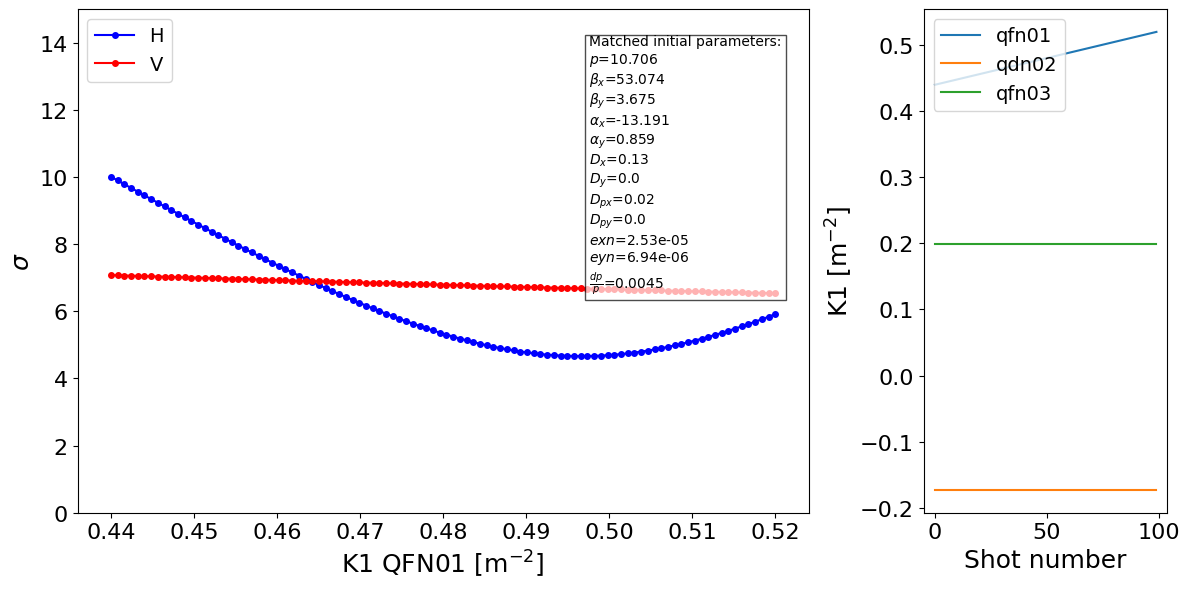

In [21]:
k_qfn01_init = 0.47969
k_qdn02_init = -0.1729
k_qfn03_init = 0.19864

k_list = []
sigH_list = []
sigV_list = []

step = 100
k_qfn01_list = np.linspace(0.44, 0.52, step)
k_qdn02_list = np.linspace(-0.1729, -0.1729, step)
k_qfn03_list = np.linspace(0.19864, 0.19864, step)

i=0
for k in range(len(k_qfn01_list)):
    madx.input("kQFN1 = "+str(k_qfn01_list[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02_list[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03_list[i])+";")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    sigH = beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige0, 1)  
    sigH_list.append(sigH)
    sigV = beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige0, 1)  
    sigV_list.append(sigV)

    i+=1

fig, ax = plt.subplots(1,2, figsize=(12, 6), width_ratios=[3,1], tight_layout=True)
ax[0].plot(k_qfn01_list, np.array(sigH_list)*1000, c="b", marker="o", markersize=4, label="H")
ax[0].plot(k_qfn01_list, np.array(sigV_list)*1000, c="r", marker="o", markersize=4, label="V");
ax[0].set_xlabel(r"K1 QFN01 [m$^{-2}$]")
ax[0].set_ylabel(r"$\sigma$")
ax[0].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn0,8)),
    r'$eyn$='+str(round(eyn0,8)),
    r'$\frac{dp}{p}$='+str(round(sige0,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
ax[0].set_ylim(0, 15)

ax[1].plot(k_qfn01_list, label="qfn01")
ax[1].plot(k_qdn02_list, label="qdn02")
ax[1].plot(k_qfn03_list, label="qfn03")
ax[1].legend(loc = "upper left")
ax[1].set_ylabel(r"K1 [m$^{-2}$]")
ax[1].set_xlabel("Shot number")



TypeError: type FloatSlider doesn't define __round__ method

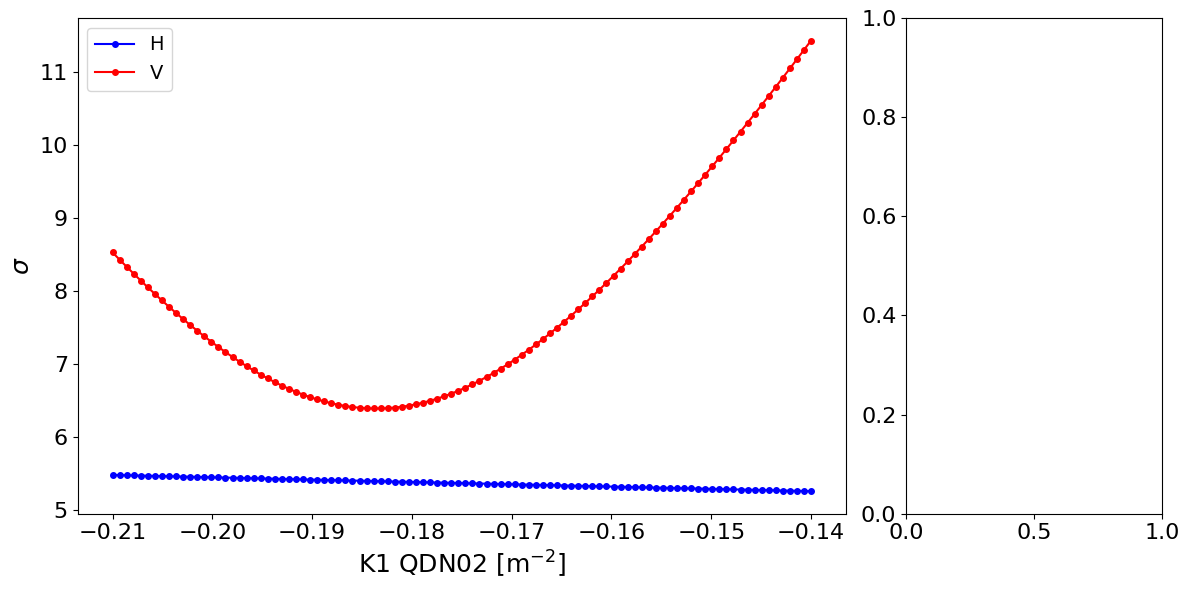

In [22]:
k_qfn01_init = 0.47969
k_qdn02_init = -0.1729
k_qfn03_init = 0.19864

k_list = []
sigH_list = []
sigV_list = []

step = 100
k_qfn01_list = np.linspace(0.47969, 0.47969, step)
k_qdn02_list = np.linspace(-0.21, -0.14, step)
k_qfn03_list = np.linspace(0.19864, 0.19864, step)

i=0
for k in range(len(k_qfn01_list)):
    madx.input("kQFN1 = "+str(k_qfn01_list[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02_list[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03_list[i])+";")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    sigH = beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige0, 1)  
    sigH_list.append(sigH)
    sigV = beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige0, 1)  
    sigV_list.append(sigV)

    i+=1

fig, ax = plt.subplots(1,2, figsize=(12, 6), width_ratios=[3,1], tight_layout=True)
ax[0].plot(k_qdn02_list, np.array(sigH_list)*1000, c="b", marker="o", markersize=4, label="H")
ax[0].plot(k_qdn02_list, np.array(sigV_list)*1000, c="r", marker="o", markersize=4, label="V");
ax[0].set_xlabel(r"K1 QDN02 [m$^{-2}$]")
ax[0].set_ylabel(r"$\sigma$")
ax[0].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
ax[0].set_ylim(0, 15)

ax[1].plot(k_qfn01_list, label="qfn01")
ax[1].plot(k_qdn02_list, label="qdn02")
ax[1].plot(k_qfn03_list, label="qfn03")
ax[1].legend(loc = "upper left")
ax[1].set_ylabel(r"K1 [m$^{-2}$]")
ax[1].set_xlabel("Shot number")

Text(0.5, 0, 'Shot number')

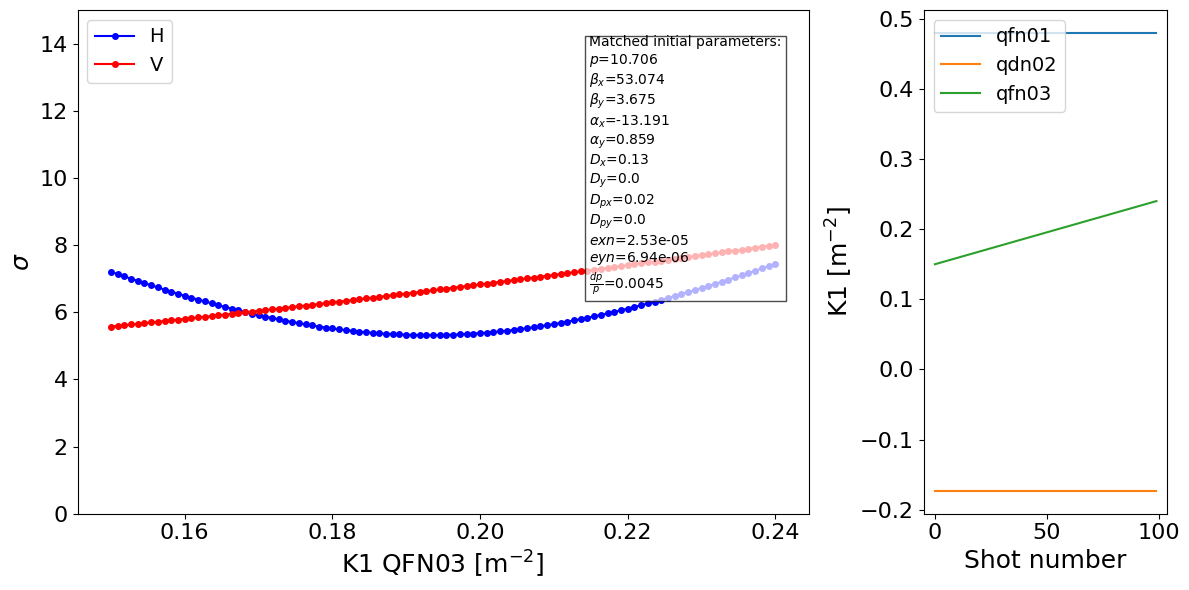

In [24]:
k_qfn01_init = 0.47969
k_qdn02_init = -0.1729
k_qfn03_init = 0.19864

k_list = []
sigH_list = []
sigV_list = []

step = 100
k_qfn01_list = np.linspace(0.47969, 0.47969, step)
k_qdn02_list = np.linspace(-0.1729, -0.1729, step)
k_qfn03_list = np.linspace(0.15, 0.24, step)

i=0
for k in range(len(k_qfn01_list)):
    madx.input("kQFN1 = "+str(k_qfn01_list[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02_list[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03_list[i])+";")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    sigH = beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige0, 1)  
    sigH_list.append(sigH)
    sigV = beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige0, 1)  
    sigV_list.append(sigV)

    i+=1

fig, ax = plt.subplots(1,2, figsize=(12, 6), width_ratios=[3,1], tight_layout=True)
ax[0].plot(k_qfn03_list, np.array(sigH_list)*1000, c="b", marker="o", markersize=4, label="H")
ax[0].plot(k_qfn03_list, np.array(sigV_list)*1000, c="r", marker="o", markersize=4, label="V");
ax[0].set_xlabel(r"K1 QFN03 [m$^{-2}$]")
ax[0].set_ylabel(r"$\sigma$")
ax[0].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn0,8)),
    r'$eyn$='+str(round(eyn0,8)),
    r'$\frac{dp}{p}$='+str(round(sige0,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
ax[0].set_ylim(0, 15)

ax[1].plot(k_qfn01_list, label="qfn01")
ax[1].plot(k_qdn02_list, label="qdn02")
ax[1].plot(k_qfn03_list, label="qfn03")
ax[1].legend(loc = "upper left")
ax[1].set_ylabel(r"K1 [m$^{-2}$]")
ax[1].set_xlabel("Shot number")



## Combined quadrupole interaction

Text(0.5, 0, 'Shot number')

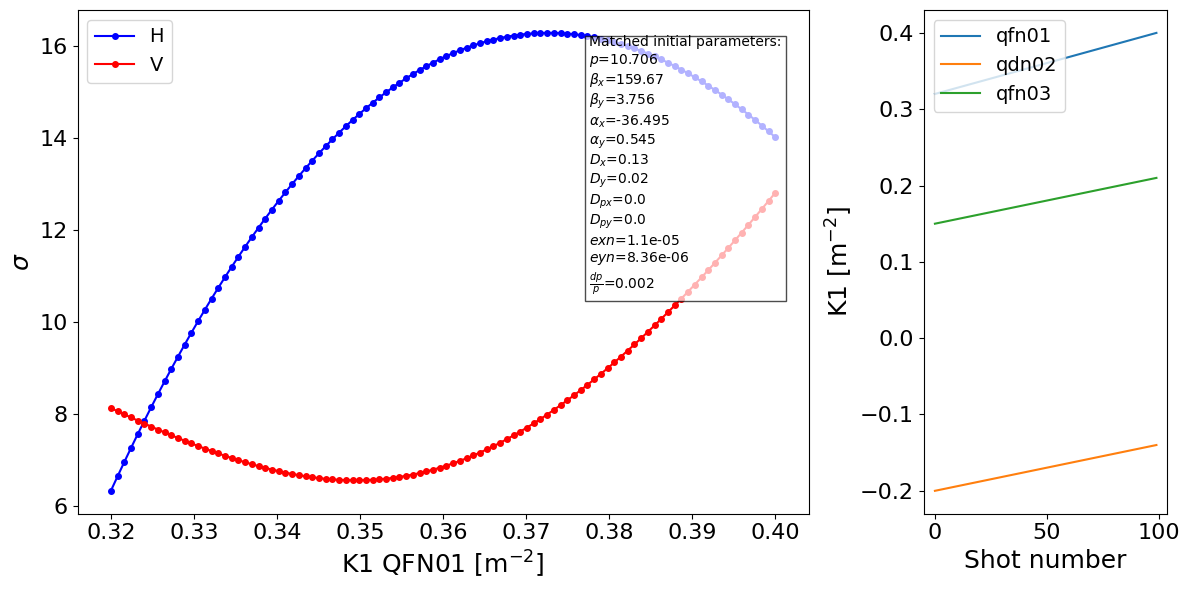

In [ ]:
k_qfn01_init = 0.47969
k_qdn02_init = -0.1729
k_qfn03_init = 0.19864

k_list = []
sigH_list = []
sigV_list = []

step = 100
k_qfn01_list = np.linspace(0.32, 0.4, step)
k_qdn02_list = np.linspace(-0.2, -0.14, step)
k_qfn03_list = np.linspace(0.15, 0.21, step)

i=0
for k in range(len(k_qfn01_list)):
    madx.input("kQFN1 = "+str(k_qfn01_list[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02_list[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03_list[i])+";")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    sigH = beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige, 1)  
    sigH_list.append(sigH)
    sigV = beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige, 1)  
    sigV_list.append(sigV)

    i+=1

fig, ax = plt.subplots(1,2, figsize=(12, 6), width_ratios=[3,1], tight_layout=True)
ax[0].plot(k_qfn01_list, np.array(sigH_list)*1000, c="b", marker="o", markersize=4, label="H")
ax[0].plot(k_qfn01_list, np.array(sigV_list)*1000, c="r", marker="o", markersize=4, label="V");
ax[0].set_xlabel(r"K1 QFN01 [m$^{-2}$]")
ax[0].set_ylabel(r"$\sigma$")
ax[0].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


ax[1].plot(k_qfn01_list, label="qfn01")
ax[1].plot(k_qdn02_list, label="qdn02")
ax[1].plot(k_qfn03_list, label="qfn03")
ax[1].legend(loc = "upper left")
ax[1].set_ylabel(r"K1 [m$^{-2}$]")
ax[1].set_xlabel("Shot number")

Text(0.5, 0, 'Shot number')

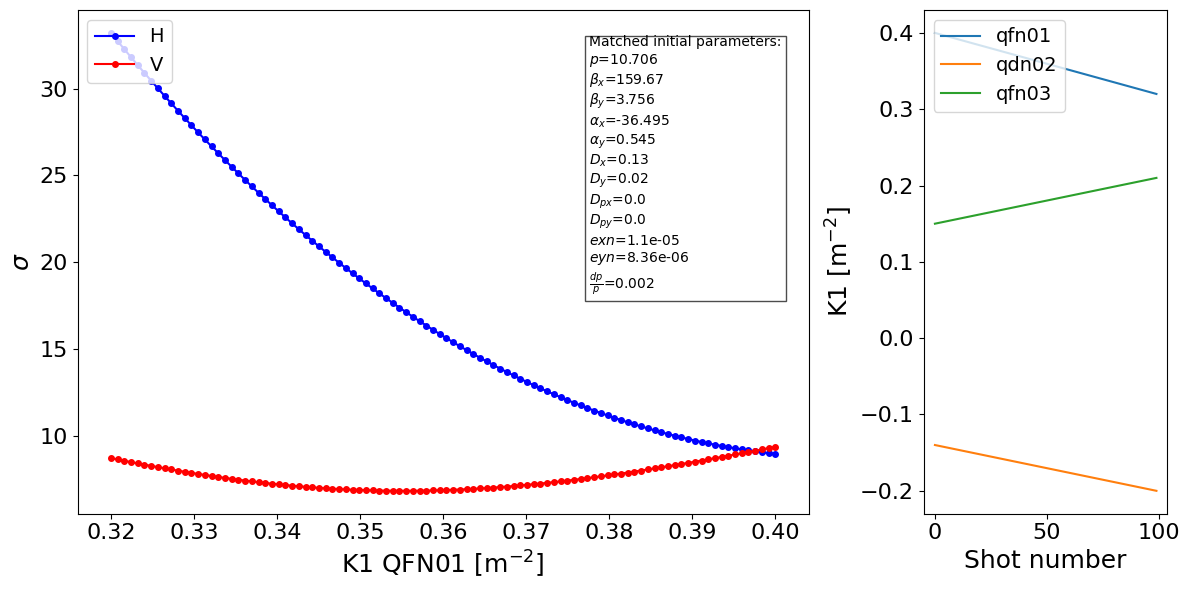

In [ ]:
k_qfn01_init = 0.47969
k_qdn02_init = -0.1729
k_qfn03_init = 0.19864

k_list = []
sigH_list = []
sigV_list = []

step = 100
k_qfn01_list = np.linspace(0.4, 0.32, step)
k_qdn02_list = np.linspace(-0.14, -0.2, step)
k_qfn03_list = np.linspace(0.15, 0.21, step)

i=0
for k in range(len(k_qfn01_list)):
    madx.input("kQFN1 = "+str(k_qfn01_list[i])+";")
    madx.input("kQDN2 = "+str(k_qdn02_list[i])+";")
    madx.input("kQFN3 = "+str(k_qfn03_list[i])+";")

    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=dx0, Dy=dy0, Dpx=dpx0, Dpy=dpy0).dframe()
    sigH = beam_size(twiss['betx'][btv], twiss['dx'][btv], ex, sige, 1)  
    sigH_list.append(sigH)
    sigV = beam_size(twiss['bety'][btv], twiss['dy'][btv], ey, sige, 1)  
    sigV_list.append(sigV)

    i+=1

fig, ax = plt.subplots(1,2, figsize=(12, 6), width_ratios=[3,1], tight_layout=True)
ax[0].plot(k_qfn01_list, np.array(sigH_list)*1000, c="b", marker="o", markersize=4, label="H")
ax[0].plot(k_qfn01_list, np.array(sigV_list)*1000, c="r", marker="o", markersize=4, label="V");
ax[0].set_xlabel(r"K1 QFN01 [m$^{-2}$]")
ax[0].set_ylabel(r"$\sigma$")
ax[0].legend(loc = "upper left")

# Box with initial parameters
textstr = '\n'.join((
    "Matched initial parameters:",
    r'$p$='+str(round(p/charge,3)),
    r'$\beta_{x}$='+str(round(betx0,3)),
    r'$\beta_{y}$='+str(round(bety0,3)),
    r'$\alpha_{x}$='+str(round(alfx0,3)),
    r'$\alpha_{y}$='+str(round(alfy0,3)),
    r'$D_{x}$='+str(round(dx0,3)),
    r'$D_{y}$='+str(round(dy0,3)),
    r'$D_{px}$='+str(round(dpx0,3)),
    r'$D_{py}$='+str(round(dpy0,3)),
    r'$exn$='+str(round(exn,8)),
    r'$eyn$='+str(round(eyn,8)),
    r'$\frac{dp}{p}$='+str(round(sige,6)),
    ))

props = dict(boxstyle='square', facecolor='white', alpha=0.7)

# place a text box in upper left in axes coords
ax[0].text(0.7, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


ax[1].plot(k_qfn01_list, label="qfn01")
ax[1].plot(k_qdn02_list, label="qdn02")
ax[1].plot(k_qfn03_list, label="qfn03")
ax[1].legend(loc = "upper left")
ax[1].set_ylabel(r"K1 [m$^{-2}$]")
ax[1].set_xlabel("Shot number")